# Key: Cathode = 0, Gate = 1, Tritium = 2

# Imports

Install tensorflow in your conda environment. Note that you need to have numpy-1.23.1. When I did this, I had to manually uninstall numpy-1.24.3 then install numpy-1.23.1, before installing tensorflow. The tensorflow install failed to install numpy-1.23.1, itself, even though it told me it was successful.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn

C:\Users\44738\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sn

In [3]:
import pandas as pd
import awkward as ak
import pyarrow.parquet as pq

import hist
from hist import Hist, axis

import matplotlib as mpl
import matplotlib.patches as patches

In [4]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'weight' : 'normal','size'   : 22}
plt.rc('font', **font)
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast

# Load data from Parquet file and convert to strings
data_path = 'padded_waveforms.parquet'
df = pd.read_parquet(data_path)
print(df.head())
arr = ak.from_parquet(data_path) #Awkward DataFrame also created for future use
print(arr.fields) #analogous to df.columns.tolist()

   runID  eventID                                              times  \
0   6940     3177  [-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...   
1   6940     7831  [-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...   
2   6940     9904  [-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...   
3   6940    15136  [-823.0, -813.0, -803.0, -793.0, -783.0, -773....   
4   6940    16478  [-813.0, -803.0, -793.0, -783.0, -773.0, -763....   

                                             samples  length          area  \
0  [0.00036996949347667396, -0.000351915950886905...    1101   9605.476562   
1  [0.0009631378925405443, 0.0009631378925405443,...     932   8454.574219   
2  [-0.003676149994134903, -0.004674938507378101,...     525  10806.775391   
3  [-0.004523166920989752, 0.0026921471580863, -0...     640  11460.135742   
4  [-0.009625015780329704, -0.004182628821581602,...     656  11764.575195   

   max_pulse_height    ext_elec          x          y          r  S2_width  \
0          2.721810 

# Normalising the Data


In this instance, we use awkward arrays. Awkward arrays work very similarly to numpy arrays but they can have different lengths – for example, the times and samples arrays are a different length for every event.

In [5]:
def normalise_array(arr):
    min_val = ak.min(arr, axis=-1)
    max_val = ak.max(arr, axis=-1)
    return (arr - min_val) / (max_val - min_val)

# Apply normalization to each column
normalised_times = normalise_array(arr['times'])
normalised_samples = normalise_array(arr['samples'])
normalised_areas = normalise_array(arr['area'])

# Print or inspect the results
print(normalised_times)
print(normalised_samples)



[[0, 0.000909, 0.00182, 0.00273, 0.00364, ..., 0.997, 0.998, 0.999, 1], ...]
[[0.00238, 0.00212, 0.00198, 0.00223, ..., 0.00251, 0.00211, 0.00133, 0], ...]


# Padding the Data

In [6]:
# Lets pad the time data first using Awkward jargon

# first, an initial check to see if data row entry (training example) has an associated label. filtering for both NaNs and None values.
missing_label_count = len(arr[(arr['label'] != 0) & (arr['label'] != 1) & (arr['label'] != 2)])
print("Number of rows with unexpected or missing labels:", missing_label_count)

nan_areas = len(arr[ak.is_none(arr['area'])])
print("Number of NaN values in area column:", nan_areas)
# print(type(electron_size))



print(len(arr['times']))
print(f"Length Before Padding: {len(arr['times'][0])}")
print("Structure of 'times':", ak.type(arr['times']))


times_lengths = ak.num(normalised_times, axis=1)
max_time_length = ak.max(times_lengths)
max_time_length_index = ak.argmax(times_lengths)

print(f'Results are: \n Max. Length = {max_time_length} \n Max. Length Index = {max_time_length_index}')

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), 'constant') for sub_array in ak.to_list(array)]
        )
    )

# Apply padding
padded_times = np.array(pad_to_max_length(normalised_times, max_time_length))

print(f"Length After Padding: {len(padded_times[0])}")
    

Number of rows with unexpected or missing labels: 0
Number of NaN values in area column: 0
7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


Now lets pad the Sample data

In [7]:
print(len(arr['samples']))
print(f"Length Before Padding: {len(normalised_samples[0])}")
print("Structure of 'times':", ak.type(arr['samples']))


samples_lengths = ak.num(normalised_samples, axis=1)
max_samples_length = ak.max(samples_lengths)
max_samples_length_index = ak.argmax(samples_lengths)

print(f'Results are: \n Max. Length = {max_samples_length} \n Max. Length Index = {max_samples_length_index}')

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), 'constant') for sub_array in ak.to_list(array)]
        )
    )

# Apply padding
padded_samples = np.array(pad_to_max_length(normalised_samples, max_samples_length))

print(f"Length After Padding: {len(padded_samples[0])}")

7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


# Creating the Training and Test Data (AwkwardArrays)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Separate times and samples as individual arrays

X = arr[['times', 'samples']] #creates a mini array from mother array with only 'times' and 'samples' columns
#print(X)
y = np.array(arr['label']) # labelled as 0,1 and 2 corresponding to cathode, gate and tritium respectively. this is the true output data#

X_combined = np.concatenate([padded_times, padded_samples], axis=1)
print(X_combined)


# Split the data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# Verify the shapes of the resulting sets
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

[[0.         0.00090909 0.00181818 ... 0.         0.         0.        ]
 [0.         0.00107411 0.00214823 ... 0.         0.         0.        ]
 [0.         0.0019084  0.00381679 ... 0.         0.         0.        ]
 ...
 [0.         0.00119474 0.00238949 ... 0.         0.         0.        ]
 [0.         0.00136799 0.00273598 ... 0.         0.         0.        ]
 [0.         0.00108225 0.0021645  ... 0.         0.         0.        ]]
Training data shape: (5836, 3656)
Test data shape: (1946, 3656)


# Plotting the S2 Area Spectrum

305.75293803418805
305.75293803418805
 Total Number of Training Examples 7782
1711
1189
4882
7782


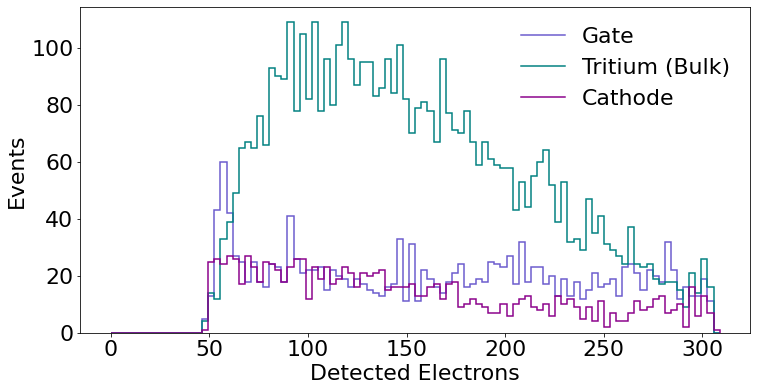

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0)

areas = arr['area']
max_area = max(areas)

bins=100
electron_size = 58.5
print(max(areas)/electron_size)

# create a histogram of area distributions for gate, tritium and cathode data.
# first, boolean masks to filter gate, tritium and cathode data from main Awkward Array.
gate_events = arr[(arr['label'] == 1)].area / electron_size
tritium_events = arr[(arr['label'] == 2)].area / electron_size
cathode_events = arr[(arr['label'] == 0)].area / electron_size

print(max(cathode_events))

print(f' Total Number of Training Examples {len(arr["label"])}')
a = len(gate_events)
b = len(cathode_events)
c = len(tritium_events)

print(a)
print(b)
print(c)
print(a+b+c)


gate_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01),label='S2 Gate Area Distribution')
gate_hist.fill(gate_events)
gate_hist.plot(color='slateblue',density=False,yerr=False,label='Gate')

tritium_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01),label='S2 Gate Tritium Distribution')
tritium_hist.fill(tritium_events)
tritium_hist.plot(color='teal',density=False,yerr=False,label='Tritium (Bulk)')

cathode_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size *1.01),label='S2 Gate Cathode Distribution')
cathode_hist.fill(cathode_events)
cathode_hist.plot(color='darkmagenta',density=False,yerr=False,label='Cathode')

ax.set(xlabel='Detected Electrons',ylabel='Events')
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False,fontsize=22) 
plt.savefig('Figures/Pulse_Spectrum.png', dpi=1800)
plt.show()

1189.0


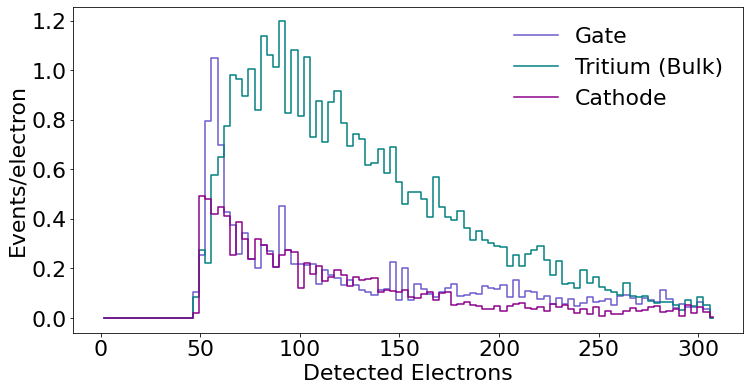

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0)

bin_edges = gate_hist.axes[0].edges  # Get bin edges from one of the histograms
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

# Retrieve and adjust counts for each histogram
gate_counts = gate_hist.view() / bin_centers
tritium_counts = tritium_hist.view() / bin_centers
cathode_counts = cathode_hist.view() / bin_centers

print(cathode_hist.view().sum())


ax.step(bin_centers, gate_counts, where='mid', color='slateblue', label='Gate')
ax.step(bin_centers, tritium_counts, where='mid', color='teal', label='Tritium (Bulk)')
ax.step(bin_centers, cathode_counts, where='mid', color='darkmagenta', label='Cathode')

ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False,fontsize=22) 
plt.savefig('Figures/eventsperelectron.png', dpi=1800)
plt.show()

# Weighting the S2 Area Spectrum

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04178364 0.29438475 0.55512552
 1.01522956 0.89674123 0.42649888 0.34641554 0.30223501 0.30315365
 0.23791094 0.24128005 0.24439488 0.31793553 0.18179549 0.41712822
 0.30789749 0.17476174 0.25905858 0.1933273  0.19710979 0.15507027
 0.15969364 0.19861158 0.16821985 0.13936696 0.1599127  0.12484751
 0.12952929 0.08933054 0.10915389 0.09963791 0.09053122 0.1772506
 0.15356565 0.11121202 0.15389618 0.08802961 0.12336123 0.12105541
 0.10100908 0.07585048 0.13755323 0.08447562 0.12177967 0.09796333
 0.09099165 0.10004295 0.09326109 0.13258904 0.11045133 0.13348438
 0.10712949 0.100745   0.1323657  0.08852721 0.11942417 0.07699293
 0.0982636  0.07489789 0.05650607 0.06433574 0.06349475 0.07103219
 0.0453765  0.08146496 0.06838503 0.07151924 0.06672721 0.06592808
 0.06131564 0.08332293 0.08984691 0.06291423 0.05854431 0.07598087
 0.0751413  

<ipython-input-11-98ebca07c6fa>:46: RuntimeWarning: divide by zero encountered in double_scalars
  gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))
<ipython-input-11-98ebca07c6fa>:53: RuntimeWarning: divide by zero encountered in double_scalars
  tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))
<ipython-input-11-98ebca07c6fa>:59: RuntimeWarning: divide by zero encountered in double_scalars
  cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()))
<ipython-input-11-98ebca07c6fa>:69: RuntimeWarning: invalid value encountered in multiply
  gate_errors = np.sqrt(gate_counts) * gate_weights /60 # * (average_counts / gate_counts.sum())
<ipython-input-11-98ebca07c6fa>:70: RuntimeWarning: invalid value encountered in multiply
  tritium_errors = np.sqrt(tritium_counts) * tritium_weights /60 # * (average_counts / tritium_counts.sum())
<ipython-input-11-98ebca07c6fa>:71: RuntimeWarning: invalid value encountered in multiply

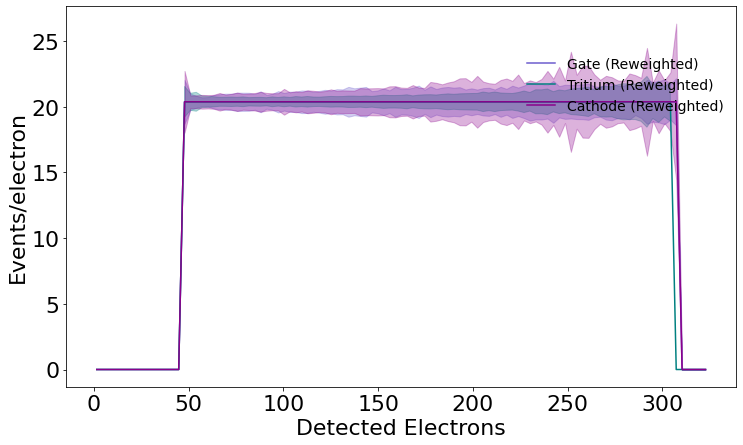

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True, sharey=True)  #Initialise new fig object to plot weighted, flat spectrum
fig.subplots_adjust(hspace=0.0)

### CODE TO DELETE: HERE FOR TESTING PURPOSES ONLY ###

areas = arr['area']
max_area = max(areas)

bins=100
electron_size = 58.5

gate_events = arr[(arr['label'] == 1)].area / electron_size

gate_hist = Hist(hist.axis.Regular(bins,0, max(areas)/electron_size ),label='S2 Gate Area Distribution')
gate_hist.fill(gate_events)

gate_counts = gate_hist.view() / bin_centers #this is the y - axis data converted to events/electron
print(gate_counts)

### 

# Calculate the target flat spectrum as the average of the three histograms
gate_data = gate_hist.view(flow=False)
tritium_data = tritium_hist.view(flow=False) 
cathode_data = cathode_hist.view(flow=False) 


print(gate_counts.sum()) # total area under the histogram (integral of histogram)
print(tritium_counts.sum()) # total area under the histogram (integral of histogram)
print(cathode_counts.sum()) # total area under the histogram (integral of histogram)

average_counts = np.mean([gate_counts.sum(), tritium_counts.sum(),cathode_counts.sum()])

#for datapoint in range(0, len(gate_data)):
    #print(gate_data[datapoint])

#gate_reweighted = np.array([
    #gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0
    #for datapoint in range(len(gate_counts))
#])

gate_weights = []
gate_reweighted  = []
for datapoint in range(len(gate_counts)):
    gate_reweighted.append(gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0)
    gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))


tritium_weights = []
tritium_reweighted = []
for datapoint in range(len(tritium_counts)):
    tritium_reweighted.append(tritium_counts[datapoint] * (1 / (tritium_counts[datapoint] / tritium_counts.sum())) if tritium_counts[datapoint] != 0 else 0)
    tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))

cathode_weights = []
cathode_reweighted = []
for datapoint in range(len(cathode_counts)):
    cathode_reweighted.append(cathode_counts[datapoint] * (1 / (cathode_counts[datapoint] / cathode_counts.sum())) if cathode_counts[datapoint] != 0 else 0)
    cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()))

gate_reweighted = np.array(gate_reweighted)
tritium_reweighted = np.array(tritium_reweighted)
cathode_reweighted = np.array(cathode_reweighted)

# print(gate_reweighted)
# print(tritium_reweighted)

#errorbars
gate_errors = np.sqrt(gate_counts) * gate_weights /60 # * (average_counts / gate_counts.sum())
tritium_errors = np.sqrt(tritium_counts) * tritium_weights /60 # * (average_counts / tritium_counts.sum())
cathode_errors = np.sqrt(cathode_counts) * cathode_weights/60 # * (average_counts / cathode_counts.sum())

# Append zeros to make the histogram look like a "tophat"
tophat_padding = 5  # Number of zeros to add
gate_reweighted = np.append(gate_reweighted, [0] * tophat_padding)
tritium_reweighted = np.append(tritium_reweighted, [0] * tophat_padding)
cathode_reweighted = np.append(cathode_reweighted, [0] * tophat_padding)

gate_errors = np.append(gate_errors, [0] * tophat_padding)
tritium_errors = np.append(tritium_errors, [0] * tophat_padding)
cathode_errors = np.append(cathode_errors, [0] * tophat_padding)

# Extend bin_centers by adding extra bins to match the "tophat" shape
bin_step = bin_centers[1] - bin_centers[0]  # Calculate the step size between bins
extended_bin_centers = np.append(bin_centers, bin_centers[-1] + bin_step * np.arange(1, tophat_padding + 1))


# Apply reweighting by multiplying the original data by the weights

# Plot reweighted data with translucent error bands
# Gate
ax.plot(extended_bin_centers, gate_reweighted * (average_counts / gate_counts.sum()), color='slateblue', label='Gate (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (gate_reweighted - gate_errors) * (average_counts / gate_counts.sum()), 
    (gate_reweighted + gate_errors) * (average_counts / gate_counts.sum()), 
    color='slateblue', alpha=0.3
)

# Tritium
ax.plot(extended_bin_centers, tritium_reweighted * (average_counts / tritium_counts.sum()), color='teal', label='Tritium (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (tritium_reweighted - tritium_errors) * (average_counts / tritium_counts.sum()), 
    (tritium_reweighted + tritium_errors) * (average_counts / tritium_counts.sum()), 
    color='teal', alpha=0.3
)

# Cathode
ax.plot(extended_bin_centers, cathode_reweighted * (average_counts / cathode_counts.sum()), color='darkmagenta', label='Cathode (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (cathode_reweighted - cathode_errors) * (average_counts / cathode_counts.sum()), 
    (cathode_reweighted + cathode_errors) * (average_counts / cathode_counts.sum()), 
    color='darkmagenta', alpha=0.3
)

#ax.step(bin_centers, gate_reweighted * (average_counts/ gate_counts.sum()), where='mid', color='slateblue', label='Gate (Reweighted)')
#ax.step(bin_centers, tritium_reweighted * (average_counts/ tritium_counts.sum()), where='mid', color='teal', label='Tritium (Bulk, Reweighted)')
#ax.step(bin_centers, cathode_reweighted * (average_counts/ cathode_counts.sum()), where='mid', color='darkmagenta', label='Cathode (Reweighted)')


ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,0.9),loc='upper right',frameon=False,fontsize=14) 
plt.savefig('Figures/weighted_pulse_spectrum.png', dpi=1800)
plt.show()

# Creating the Weight Array to Feed into CNN

In [12]:
gate_weights = np.array(gate_weights)
gate_weights = np.where(np.isinf(gate_weights), 0, gate_weights)

tritium_weights = np.array(tritium_weights)
tritium_weights = np.where(np.isinf(tritium_weights), 0, tritium_weights)

cathode_weights = np.array(cathode_weights)
cathode_weights = np.where(np.isinf(cathode_weights), 0, cathode_weights)


#gate_weights = gate_weights.ravel() # gate_weights was found to be a 2D array with only 1 row which prohibited proper indexing. ravel() flattens to 1D ndarray.
print(f'these are da {gate_weights.size}')


#print(gate_data)
#print(gate_weights)

print(gate_data.sum())
print(tritium_data.sum())
print(cathode_data.sum())

def subdataset_total_weights(dataset_weights, n_data_per_bin):
    n_data_per_bin = np.array(n_data_per_bin, dtype=int) #creates a copy of array that is an ndarray with every element being an integer
    weight_list = []
    for i in range(bins):
        weight_list.extend([dataset_weights[i]] * n_data_per_bin[i])
    return np.array(weight_list)

g_weights = subdataset_total_weights(gate_weights, gate_data)
t_weights = subdataset_total_weights(tritium_weights, tritium_data)
c_weights = subdataset_total_weights(cathode_weights, cathode_data)

print(g_weights.size + t_weights.size + c_weights.size)
print(type(g_weights))
print(len(arr))


#arr['weight'] = all_weights #the final line to add all weights for each subdataset (gate, cathode and tritium) to main awkward data frame. then can feed into CNN easy.


these are da 100
1711.0
4882.0
1189.0
7782
<class 'numpy.ndarray'>
7782


# Creating and Populating the New Weight Column in the Main Dataframe

In [13]:
weight_column_4_mainarray = np.zeros(len(arr))
# print(len(arr['weights'])) #check to ensure its same length as number of training examples

# Now we need to create an iterative loop that finds a cathode, gate or tritium training example and populates its assoicated weight with the correct weight parameter from its respective weight array

gate_event_counter = 0
cathode_event_counter = 0
tritium_event_counter = 0

print(len(t_weights))

for i in range(len(arr)):
    if arr['label'][i] == 0: # Cathode
        # print(g_weights[i])
        weight_column_4_mainarray[i] = c_weights[gate_event_counter]
        gate_event_counter += 1
    elif arr['label'][i] == 1: # Gate
        weight_column_4_mainarray[i] = g_weights[cathode_event_counter]
        cathode_event_counter += 1
    else: # Tritium (as we have already verified there are no None or NaN entries)
        weight_column_4_mainarray[i] = t_weights[tritium_event_counter]
        tritium_event_counter += 1

arr['weights'] = weight_column_4_mainarray # a new weight column has been initialised!

4882


# Convolutional Neural Network

Convolutional layers should improve the accuracy further but will even longer to run. You should try to understand what filters, pooling, and kernal size are. These are the hyperparameters you need to mess around with, as well as the number of convolutional layers. The filters will be used to look for certain features of the S2 waveforms so I think the kernal size should be decided based on the size of features you are trying to select. Here is a descriptive link: https://www.simplilearn.com/tutorials/deep-learning-tutorial/convolutional-neural-network#:~:text=A%20convolutional%20neural%20network%20is,classify%20objects%20in%20an%20image. This made my computer start to overheat, hence the desire to use a gpu, but maybe we are okay.

In [14]:
convoNN = keras.Sequential([
    # First 1D convolution layer
    keras.layers.Conv1D(filters=28, kernel_size=3, activation='relu', input_shape=(3656, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Second 1D convolution layer
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Flatten layer to connect to dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Adjust output size for the number of classes
])

# Compile the model
convoNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#CNN with 7 layers
#the first two Conv2D extract spatial features from the image- i.e. there will be 28 filters that will scan the image for patterns, each filter extracts different features from the image (e.g.textures, edges)
#max Pooling layer performs down-sampling to resduce spatial dimensions
#(2,2) specifies a pooling window which means the layer will take the max value from every 2*2 region
#flatten layer converts information from 2D map to a 1D vector
#64 layer is a dense layer with 64 neurons
#10 layer is our 10 neuron layer that provides a class (digit 0-1)

In [15]:
convoNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [16]:
weights_np = ak.to_numpy(arr['weights'])
print(len(weights_np))
# An issue arises here initially as arr['weights'] is an awkward array. Keras only recognises and deals with a NumPy array therefore conversion is neccessary
# Another issue also arises in that the test and train data do not have asscoated weights as the weights column was initialised after the split was made
# 'arr' is the original dataset
normalized_area = ak.to_numpy(arr['area'] / electron_size)  # converting 'area' to detected electrons by dividing by 58.5

labels = arr['label']
# Assuming you already have 'X_combined' and 'labels' prepared
# Split the data (include 'area' normalization within the split for alignment)
X_train, X_test, y_train, y_test, area_train, area_test, weights_train, weights_test = train_test_split(
    X_combined, labels, normalized_area, weights_np, test_size=0.25, random_state=42
)
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of weights_train:", len(weights_train))
print("Shape of weights_train:", weights_train.shape)
print("Shape of X_train:", X_train.shape)




y_train = np.array(y_train) # this is neccessary as train_test_split often returns lists instead of ndarrays but Keras.model.fit requires the functionality of ndarrays
y_test = np.array(y_test) # //
print("Shape of y_train:", y_train.shape)

convoNN.fit(X_train, y_train, sample_weight=weights_train, epochs=5) 




7782
Length of X_train: 5836
Length of y_train: 5836
Length of weights_train: 5836
Shape of weights_train: (5836,)
Shape of X_train: (5836, 3656)
Shape of y_train: (5836,)
Epoch 1/5
183/183 [==============================] - 17s 91ms/step - loss: 49.2033 - accuracy: 0.8317
Epoch 2/5
183/183 [==============================] - 16s 86ms/step - loss: 40.9662 - accuracy: 0.8564
Epoch 3/5
183/183 [==============================] - 17s 94ms/step - loss: 39.1971 - accuracy: 0.8651
Epoch 4/5
183/183 [==============================] - 18s 98ms/step - loss: 34.3093 - accuracy: 0.8727
Epoch 5/5
183/183 [==============================] - 17s 95ms/step - loss: 32.0484 - accuracy: 0.8819


In [17]:
X_test_reshaped = X_test.reshape(-1, 3656, 1)
print(X_test_reshaped.shape)
convoNN.evaluate(X_test_reshaped, y_test)

(1946, 3656, 1)
61/61 [==============================] - 2s 22ms/step - loss: 0.3066 - accuracy: 0.8695


[0.30659887194633484, 0.8694758415222168]

# Visualising the Model Classification Effectiveness: The Probability Distribution

# CNN Filter Size

In [18]:
print("X_train shape:", X_train.shape)


X_train shape: (5836, 3656)


In [19]:
import numpy as np

# Define the padding length
padding_length = 500  # 5 ms worth of samples at 10 ns per sample

# Add zero-padding on each side of the data (only along the time dimension for 2D data)
X_train_padded = np.pad(X_train, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
X_test_padded = np.pad(X_test, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)

print("Original shape:", X_train.shape)
print("Padded shape:", X_train_padded.shape)



Original shape: (5836, 3656)
Padded shape: (5836, 4656)


In [20]:
convoNN = keras.Sequential([
    # First 1D convolution layer
    keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu', input_shape=(3656, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    
    
    # Flatten layer to connect to dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Adjust output size for the number of classes
])

# Compile the model
convoNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [21]:
convoNN.fit(X_train, y_train, sample_weight=weights_train, epochs=5) 

Epoch 1/5
183/183 [==============================] - 31s 168ms/step - loss: 48.6179 - accuracy: 0.8334
Epoch 2/5
183/183 [==============================] - 30s 164ms/step - loss: 41.7977 - accuracy: 0.8454
Epoch 3/5
183/183 [==============================] - 30s 165ms/step - loss: 39.2294 - accuracy: 0.8660
Epoch 4/5
183/183 [==============================] - 33s 178ms/step - loss: 35.8964 - accuracy: 0.8658
Epoch 5/5
183/183 [==============================] - 34s 187ms/step - loss: 35.3358 - accuracy: 0.8770


In [22]:
X_test_reshaped = X_test.reshape(-1, 3656, 1)
print(X_test_reshaped.shape)
convoNN.evaluate(X_test_reshaped, y_test)

(1946, 3656, 1)
61/61 [==============================] - 3s 42ms/step - loss: 0.3175 - accuracy: 0.8669


[0.3174647092819214, 0.866906464099884]

Training model with kernel size: 1000 samples
Kernel Size (samples): 1000, Mean Accuracy: 0.8861, SEM: 0.0012
Training model with kernel size: 800 samples
Kernel Size (samples): 800, Mean Accuracy: 0.8896, SEM: 0.0036
Training model with kernel size: 600 samples
Kernel Size (samples): 600, Mean Accuracy: 0.8913, SEM: 0.0018
Training model with kernel size: 400 samples
Kernel Size (samples): 400, Mean Accuracy: 0.8921, SEM: 0.0012
Training model with kernel size: 200 samples
Kernel Size (samples): 200, Mean Accuracy: 0.8707, SEM: 0.0073
Training model with kernel size: 100 samples
Kernel Size (samples): 100, Mean Accuracy: 0.8853, SEM: 0.0018
Training model with kernel size: 100 samples
Kernel Size (samples): 100, Mean Accuracy: 0.8866, SEM: 0.0003
Training model with kernel size: 90 samples
Kernel Size (samples): 90, Mean Accuracy: 0.8848, SEM: 0.0003
Training model with kernel size: 80 samples
Kernel Size (samples): 80, Mean Accuracy: 0.8797, SEM: 0.0045
Training model with kernel siz

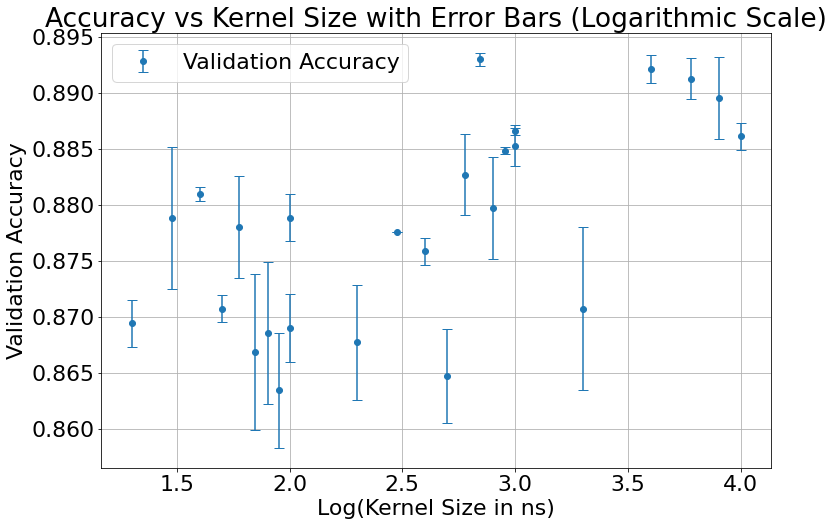

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define kernel sizes (combined from all ranges)
kernel_sizes_10us_to_1us = [1000, 800, 600, 400, 200, 100]  # [10 µs, 8 µs, ..., 1 µs]
kernel_sizes_1us_to_100ns = list(range(100, 9, -10))        # [100, 90, ..., 10]
kernel_sizes_100ns_to_20ns = list(range(10, 1, -1))         # [10, 9, ..., 2]
combined_kernel_sizes = kernel_sizes_10us_to_1us + kernel_sizes_1us_to_100ns + kernel_sizes_100ns_to_20ns

# Placeholder for accuracies and errors
combined_accuracies = []
combined_errors = []  # For standard deviation or SEM

# Number of runs per kernel size
num_runs = 1  # Run the model 3 times for each kernel size

# Loop over each kernel size
for kernel_size in combined_kernel_sizes:
    accuracies = []  # Store accuracies for each run
    
    print(f"Training model with kernel size: {kernel_size} samples")
    for _ in range(num_runs):
        # Define the CNN model
        model = Sequential([
            Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ])
        
        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model and get the accuracy
        history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
        val_accuracy = history.history['val_accuracy'][-1]
        accuracies.append(val_accuracy)
    
    # Calculate the mean and standard deviation for the kernel size
    mean_accuracy = np.mean(accuracies)
    std_dev = np.std(accuracies)  # Standard deviation
    sem = std_dev / np.sqrt(num_runs)  # Standard error of the mean

    # Store the mean accuracy and error (use SEM or std_dev based on preference)
    combined_accuracies.append(mean_accuracy)
    combined_errors.append(sem)  # Replace with `std_dev` if you want total variability

    print(f"Kernel Size (samples): {kernel_size}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {sem:.4f}")

# Convert kernel sizes to nanoseconds for plotting
combined_kernel_sizes_ns = [size * 10 for size in combined_kernel_sizes]  # Convert samples to nanoseconds

# Plot the data with error bars
plt.figure(figsize=(12, 8))
plt.errorbar(np.log10(combined_kernel_sizes_ns), combined_accuracies, yerr=combined_errors, fmt='o', label='Validation Accuracy', capsize=5)

# Add labels and title
plt.xlabel("Log(Kernel Size in ns)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Kernel Size with Error Bars (Logarithmic Scale)")
plt.grid(True)
plt.legend()
plt.show()


Training model with kernel size: 1000 samples
37/37 [==============================] - 2s 60ms/step
Kernel Size (samples): 1000
  Cathode Mean Accuracy: 0.4912
  Tritium Mean Accuracy: 0.9507
  Gate Mean Accuracy: 0.9390
Training model with kernel size: 800 samples
37/37 [==============================] - 2s 41ms/step
Kernel Size (samples): 800
  Cathode Mean Accuracy: 0.5468
  Tritium Mean Accuracy: 0.9493
  Gate Mean Accuracy: 0.9309
Training model with kernel size: 600 samples
37/37 [==============================] - 1s 33ms/step
Kernel Size (samples): 600
  Cathode Mean Accuracy: 0.7895
  Tritium Mean Accuracy: 0.8880
  Gate Mean Accuracy: 0.9370
Training model with kernel size: 400 samples
37/37 [==============================] - 1s 28ms/step
Kernel Size (samples): 400
  Cathode Mean Accuracy: 0.6170
  Tritium Mean Accuracy: 0.9240
  Gate Mean Accuracy: 0.9512
Training model with kernel size: 200 samples
37/37 [==============================] - 1s 17ms/step
Kernel Size (samples): 

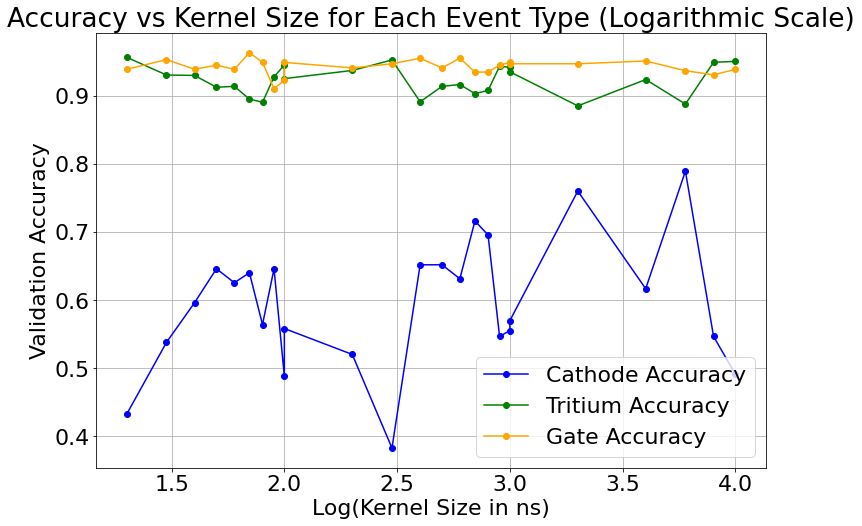

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define kernel sizes (combined from all ranges)
kernel_sizes_10us_to_1us = [1000, 800, 600, 400, 200, 100]  # [10 µs, 8 µs, ..., 1 µs]
kernel_sizes_1us_to_100ns = list(range(100, 9, -10))        # [100, 90, ..., 10]
kernel_sizes_100ns_to_20ns = list(range(10, 1, -1))         # [10, 9, ..., 2]
combined_kernel_sizes = kernel_sizes_10us_to_1us + kernel_sizes_1us_to_100ns + kernel_sizes_100ns_to_20ns

# Placeholder for accuracies (one list per event type)
cathode_accuracies = []
tritium_accuracies = []
gate_accuracies = []

# Number of runs per kernel size
num_runs = 2  # Run the model 3 times for each kernel size

# Loop over each kernel size
for kernel_size in combined_kernel_sizes:
    cathode_run_accuracies = []  # Store accuracies for cathode
    tritium_run_accuracies = []  # Store accuracies for tritium
    gate_run_accuracies = []     # Store accuracies for gate
    
    print(f"Training model with kernel size: {kernel_size} samples")
    for _ in range(num_runs):
        # Define the CNN model
        model = Sequential([
            Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ])
        
        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model
        history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

        # Get predictions for validation set
        val_split = int(0.2 * len(X_train_padded))  # Assuming 20% validation split
        X_val, y_val = X_train_padded[-val_split:], y_train[-val_split:]
        y_pred = np.argmax(model.predict(X_val), axis=1)

        # Calculate accuracies for each event type
        cathode_accuracy = np.mean(y_pred[y_val == 0] == 0)  # True positives for cathode
        tritium_accuracy = np.mean(y_pred[y_val == 2] == 2)  # True positives for tritium
        gate_accuracy = np.mean(y_pred[y_val == 1] == 1)     # True positives for gate
        
        # Store accuracies
        cathode_run_accuracies.append(cathode_accuracy)
        tritium_run_accuracies.append(tritium_accuracy)
        gate_run_accuracies.append(gate_accuracy)
    
    # Calculate mean accuracy across runs
    cathode_accuracies.append(np.mean(cathode_run_accuracies))
    tritium_accuracies.append(np.mean(tritium_run_accuracies))
    gate_accuracies.append(np.mean(gate_run_accuracies))

    print(f"Kernel Size (samples): {kernel_size}")
    print(f"  Cathode Mean Accuracy: {cathode_accuracies[-1]:.4f}")
    print(f"  Tritium Mean Accuracy: {tritium_accuracies[-1]:.4f}")
    print(f"  Gate Mean Accuracy: {gate_accuracies[-1]:.4f}")

# Convert kernel sizes to nanoseconds for plotting
combined_kernel_sizes_ns = [size * 10 for size in combined_kernel_sizes]  # Convert samples to nanoseconds

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(np.log10(combined_kernel_sizes_ns), cathode_accuracies, marker='o', label='Cathode Accuracy', color='blue')
plt.plot(np.log10(combined_kernel_sizes_ns), tritium_accuracies, marker='o', label='Tritium Accuracy', color='green')
plt.plot(np.log10(combined_kernel_sizes_ns), gate_accuracies, marker='o', label='Gate Accuracy', color='orange')

# Add labels and title
plt.xlabel("Log(Kernel Size in ns)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Kernel Size for Each Event Type (Logarithmic Scale)")
plt.grid(True)
plt.legend()
plt.show()


Training model with kernel size: 1000 samples
Kernel Size (samples): 1000
  Training Accuracy: 0.8877
  Test Accuracy: 0.8916
Training model with kernel size: 800 samples
Kernel Size (samples): 800
  Training Accuracy: 0.8918
  Test Accuracy: 0.8905
Training model with kernel size: 600 samples
Kernel Size (samples): 600
  Training Accuracy: 0.8933
  Test Accuracy: 0.8834
Training model with kernel size: 400 samples
Kernel Size (samples): 400
  Training Accuracy: 0.8871
  Test Accuracy: 0.8859
Training model with kernel size: 200 samples
Kernel Size (samples): 200
  Training Accuracy: 0.8916
  Test Accuracy: 0.8895
Training model with kernel size: 100 samples
Kernel Size (samples): 100
  Training Accuracy: 0.8897
  Test Accuracy: 0.8911
Training model with kernel size: 100 samples
Kernel Size (samples): 100
  Training Accuracy: 0.8933
  Test Accuracy: 0.8700
Training model with kernel size: 90 samples
Kernel Size (samples): 90
  Training Accuracy: 0.8897
  Test Accuracy: 0.8854
Training

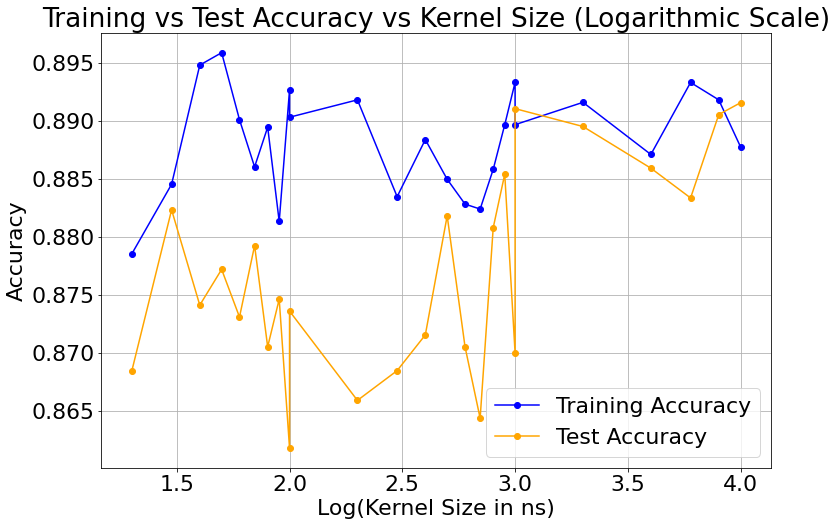

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define kernel sizes (combined from all ranges)
kernel_sizes_10us_to_1us = [1000, 800, 600, 400, 200, 100]  # [10 µs, 8 µs, ..., 1 µs]
kernel_sizes_1us_to_100ns = list(range(100, 9, -10))        # [100, 90, ..., 10]
kernel_sizes_100ns_to_20ns = list(range(10, 1, -1))         # [10, 9, ..., 2]
combined_kernel_sizes = kernel_sizes_10us_to_1us + kernel_sizes_1us_to_100ns + kernel_sizes_100ns_to_20ns

# Placeholder for accuracies
training_accuracies = []
test_accuracies = []

# Loop over each kernel size
for kernel_size in combined_kernel_sizes:
    print(f"Training model with kernel size: {kernel_size} samples")

    # Define the CNN model
    model = Sequential([
        Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    # Record training accuracy (last epoch)
    training_accuracy = history.history['accuracy'][-1]
    training_accuracies.append(training_accuracy)
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
    test_accuracies.append(test_accuracy)
    
    print(f"Kernel Size (samples): {kernel_size}")
    print(f"  Training Accuracy: {training_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")

# Convert kernel sizes to nanoseconds for plotting
combined_kernel_sizes_ns = [size * 10 for size in combined_kernel_sizes]  # Convert samples to nanoseconds

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(np.log10(combined_kernel_sizes_ns), training_accuracies, marker='o', label='Training Accuracy', color='blue')
plt.plot(np.log10(combined_kernel_sizes_ns), test_accuracies, marker='o', label='Test Accuracy', color='orange')

# Add labels and title
plt.xlabel("Log(Kernel Size in ns)")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy vs Kernel Size (Logarithmic Scale)")
plt.grid(True)
plt.legend()
plt.show()


Trimming 0 values from the front
Front Trim: 0, Test Accuracy: 0.8839
Trimming 100 values from the front
Front Trim: 100, Test Accuracy: 0.8839
Trimming 200 values from the front
Front Trim: 200, Test Accuracy: 0.8890
Trimming 300 values from the front
Front Trim: 300, Test Accuracy: 0.8715
Accuracy decreased by more than 0.01. Stopping.


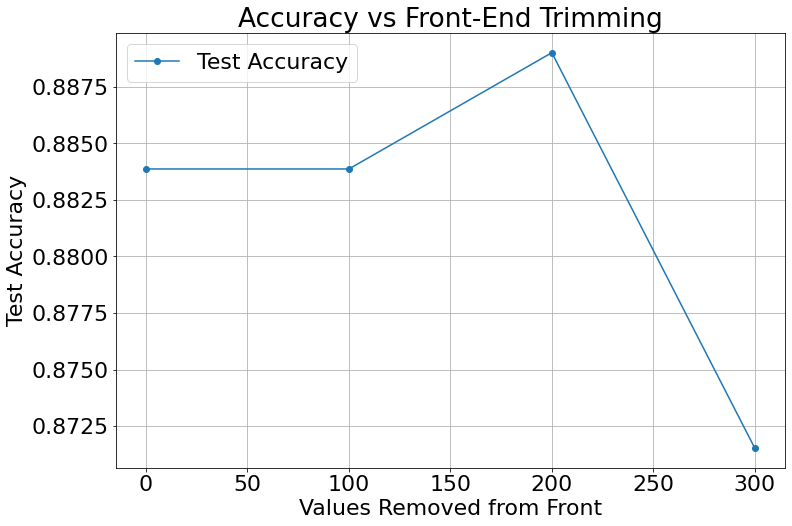

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Fixed kernel size
kernel_size = 100  # For example, 1 µs (100 samples)

# Placeholder for accuracies
front_trim_accuracies = []

# Loop to incrementally remove values from the front
for front_trim in range(0, X_train_padded.shape[1], 100):  # Remove in steps of 100
    print(f"Trimming {front_trim} values from the front")

    # Trim the front of the waveform
    X_train_trimmed = X_train_padded[:, front_trim:]
    X_test_trimmed = X_test_padded[:, front_trim:]

    # Define the CNN model
    model = Sequential([
        Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_trimmed.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_trimmed, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_trimmed, y_test, verbose=0)
    front_trim_accuracies.append(test_accuracy)
    
    print(f"Front Trim: {front_trim}, Test Accuracy: {test_accuracy:.4f}")

    # Stop if accuracy decreases by more than 0.01
    if len(front_trim_accuracies) > 1 and (front_trim_accuracies[-1] < front_trim_accuracies[-2] - 0.01):
        print("Accuracy decreased by more than 0.01. Stopping.")
        break

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(0, len(front_trim_accuracies) * 100, 100), front_trim_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Values Removed from Front")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Front-End Trimming")
plt.grid(True)
plt.legend()
plt.show()



Trimming 0 values from the front
Front Trim: 0, Test Accuracy: 0.8895
Trimming 50 values from the front
Front Trim: 50, Test Accuracy: 0.8916
Trimming 100 values from the front
Front Trim: 100, Test Accuracy: 0.8900
Trimming 150 values from the front
Front Trim: 150, Test Accuracy: 0.8869
Trimming 200 values from the front
Front Trim: 200, Test Accuracy: 0.8628
Accuracy decreased by more than 0.01. Stopping.


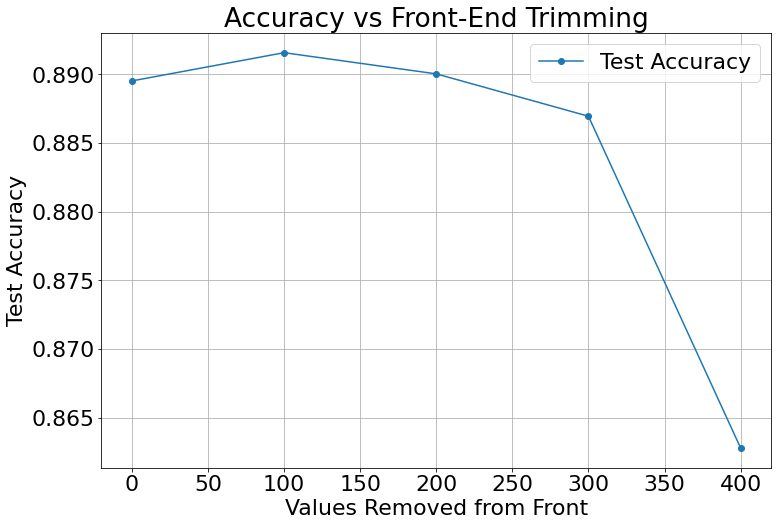

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Fixed kernel size
kernel_size = 100  # For example, 1 µs (100 samples)

# Placeholder for accuracies
front_trim_accuracies = []

# Loop to incrementally remove values from the front
for front_trim in range(0, X_train_padded.shape[1], 50):  # Remove in steps of 100
    print(f"Trimming {front_trim} values from the front")

    # Trim the front of the waveform
    X_train_trimmed = X_train_padded[:, front_trim:]
    X_test_trimmed = X_test_padded[:, front_trim:]

    # Define the CNN model
    model = Sequential([
        Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_trimmed.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_trimmed, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_trimmed, y_test, verbose=0)
    front_trim_accuracies.append(test_accuracy)
    
    print(f"Front Trim: {front_trim}, Test Accuracy: {test_accuracy:.4f}")

    # Stop if accuracy decreases by more than 0.01
    if len(front_trim_accuracies) > 1 and (front_trim_accuracies[-1] < front_trim_accuracies[-2] - 0.01):
        print("Accuracy decreased by more than 0.01. Stopping.")
        break

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(0, len(front_trim_accuracies) * 100, 100), front_trim_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Values Removed from Front")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Front-End Trimming")
plt.grid(True)
plt.legend()
plt.show()

Trimming 0 values from the back
Back Trim: 0, Test Accuracy: 0.8798
Trimming 10 values from the back
Back Trim: 10, Test Accuracy: 0.8880
Trimming 20 values from the back
Back Trim: 20, Test Accuracy: 0.8911
Trimming 30 values from the back
Back Trim: 30, Test Accuracy: 0.8880
Accuracy started to decrease. Stopping.


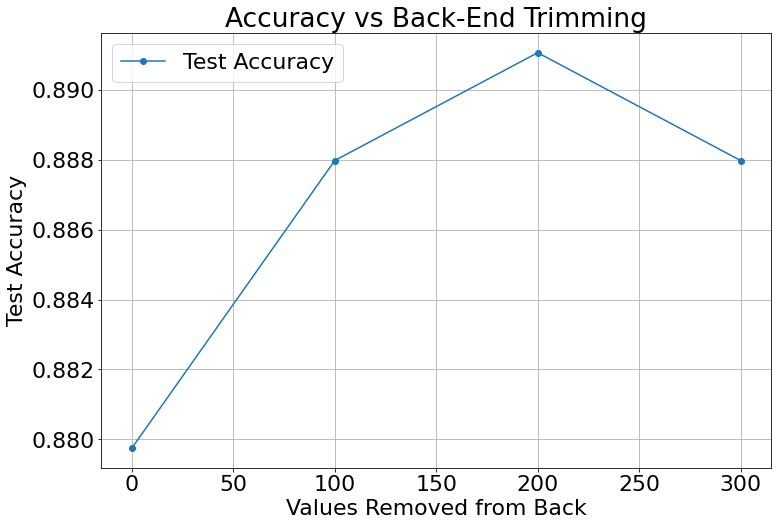

In [33]:
# Placeholder for accuracies
back_trim_accuracies = []

# Loop to incrementally remove values from the back
for back_trim in range(0, X_train_padded.shape[1], 10):  # Remove in steps of 100
    print(f"Trimming {back_trim} values from the back")

    # Trim the back of the waveform
    X_train_trimmed = X_train_padded[:, :-back_trim] if back_trim > 0 else X_train_padded
    X_test_trimmed = X_test_padded[:, :-back_trim] if back_trim > 0 else X_test_padded

    # Define the CNN model
    model = Sequential([
        Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_trimmed.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_trimmed, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_trimmed, y_test, verbose=0)
    back_trim_accuracies.append(test_accuracy)
    
    print(f"Back Trim: {back_trim}, Test Accuracy: {test_accuracy:.4f}")

    # Stop if accuracy starts decreasing
    if len(back_trim_accuracies) > 1 and test_accuracy < back_trim_accuracies[-2]:
        print("Accuracy started to decrease. Stopping.")
        break

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(0, len(back_trim_accuracies) * 100, 100), back_trim_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Values Removed from Back")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Back-End Trimming")
plt.grid(True)
plt.legend()
plt.show()
